# Azure usage report

In [48]:
import report_utils as ru
import pandas as pd
from psycopg2 import sql
import matplotlib.pyplot as plt

In [103]:
query = sql.SQL(
    """SELECT
    u.*,
    COALESCE(a.total_approved, 0) AS total_approved,
    COALESCE(b.total_allocated, 0) AS total_allocated,
    COALESCE(c.total_financed, 0) AS total_financed
    FROM
        ea.usage u
    LEFT JOIN (
        SELECT
            subscription_id,
            SUM(amount) AS total_approved
        FROM
            ea.approvals
        WHERE
            date_to BETWEEN '2023-04-06' AND '2024-04-05'
        GROUP BY
            subscription_id
    ) a ON u.subscription_id = a.subscription_id
    LEFT JOIN (
        SELECT
            subscription_id,
            SUM(amount) AS total_allocated
        FROM
            ea.allocations
        WHERE
            time_created BETWEEN '2023-04-06' AND '2024-04-05'
        GROUP BY
            subscription_id
    ) b ON u.subscription_id = b.subscription_id
    LEFT JOIN (
        SELECT
            subscription_id,
            SUM(amount) AS total_financed
        FROM
            ea.finance
        WHERE
            date_to BETWEEN '2023-04-06' AND '2024-04-05'
        GROUP BY
            subscription_id
    ) c ON u.subscription_id = c.subscription_id
    WHERE
        u.billing_period_start_date BETWEEN '2023-04-06' AND '2024-04-05';"""
)

df = ru.run_query(query)

In [144]:
# Total spending for the current fiscal year for each subscription
dfagg = df.groupby("subscription_name").agg({"total_cost": "sum", "total_approved": "first", "total_financed": "first"})
dfagg["core_approval"] = dfagg["total_approved"] - dfagg["total_financed"]
dfagg["utilisation"] = (dfagg["total_approved"] - dfagg["total_cost"]) / dfagg["total_approved"]

print(
    f"Total approved: {dfagg['total_approved'].sum()}\n"
    f"Total project approved: {dfagg['total_financed'].sum()}\n"
    f"Total core approved: {dfagg['core_approval'].sum()}\n"
    f"Total spending: {dfagg['total_cost'].sum()}\n"
    f"Total project spending: {dfagg[dfagg['total_financed'] > 0]['total_cost'].sum()}\n"
    f"Total core spending: {dfagg[dfagg['total_financed'] == 0]['total_cost'].sum()}"
)

dfagg[dfagg['total_financed'] > 0]

dfagg[dfagg['core_approval'] > 0]


Total approved: 399120.4954965279
Total project approved: 103327.0
Total core approved: 295793.4954965279
Total spending: 209910.2438915169
Total project spending: 122929.3666357699
Total core spending: 86980.87725574701


,total_cost,total_approved,total_financed,core_approval,utilisation
subscription_name,,,,,
3D Bridge Data Management Plan,198.286314,273.286023,0.0,273.286023,2.744367e-01
AIrsenal,122.949036,1000.000000,0.0,1000.000000,8.770510e-01
ARC,392.815022,3426.950000,0.0,3426.950000,8.853747e-01
AZ-900 echalstrey,44.902214,100.000000,0.0,100.000000,5.509779e-01
AZ-900 istenson,297.085850,300.000000,0.0,300.000000,9.713834e-03
AZ-900 jpalmer,47.448832,49.428462,0.0,49.428462,4.005040e-02
AZ-900 pwochner,74.927340,100.000000,0.0,100.000000,2.507266e-01
Alternative Distribution Networks,148.443436,300.000000,0.0,300.000000,5.051885e-01
CLAMMs,108.104284,300.000000,0.0,300.000000,6.396524e-01


In [115]:
df["month-year"] = pd.to_datetime(df["billing_period_start_date"]).dt.strftime("%b-%Y")
pivot = df.pivot_table(index="month-year", values="total_cost", aggfunc="sum")
pivot

,total_cost
month-year,
Aug-2023,48596.808584
Jul-2023,48717.213147
Jun-2023,48728.703349
May-2023,52030.659817
Sep-2023,11836.858994


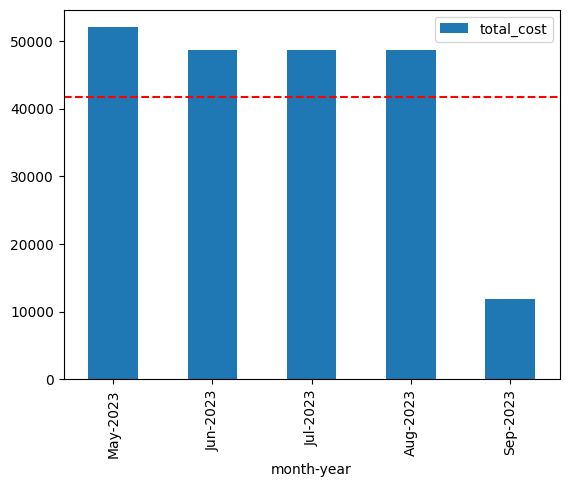

In [116]:
budget = 500000

pivot.index = pd.to_datetime(pivot.index, format="%b-%Y")
pivot.sort_index(inplace=True)
pivot["month-year"] = pivot.index.strftime("%b-%Y")
pivot.plot(kind="bar", x="month-year", y="total_cost")
plt.axhline(y=budget/12, color='r', linestyle='--', label='Threshold')

In [73]:
date_range = pd.date_range(start=pivot.index.max() + pd.DateOffset(months=1), end=pd.Timestamp('2024-05-01'), freq='M')
months_between = date_range.strftime('%b-%Y')
new_rows = pd.DataFrame({'month-year': months_between, 'total_cost': 0})
pivot = pd.concat([pivot, new_rows], ignore_index=True)

pivot['cumulative_total_cost'] = pivot['total_cost'].cumsum()
pivot['expected_cost'] = budget/12
pivot['cumulative_expected_cost'] = pivot['expected_cost'].cumsum()

,total_cost,month-year,cumulative_total_cost,expected_cost,cumulative_expected_cost
0,52030.659817,May-2023,52030.659817,41666.666667,41666.666667
1,48728.703349,Jun-2023,100759.363166,41666.666667,83333.333333
2,48717.213147,Jul-2023,149476.576314,41666.666667,125000.000000
3,48596.808584,Aug-2023,198073.384898,41666.666667,166666.666667
4,11836.858994,Sep-2023,209910.243892,41666.666667,208333.333333
5,0.000000,Oct-2023,209910.243892,41666.666667,250000.000000
6,0.000000,Nov-2023,209910.243892,41666.666667,291666.666667
7,0.000000,Dec-2023,209910.243892,41666.666667,333333.333333
8,0.000000,Jan-2024,209910.243892,41666.666667,375000.000000
9,0.000000,Feb-2024,209910.243892,41666.666667,416666.666667


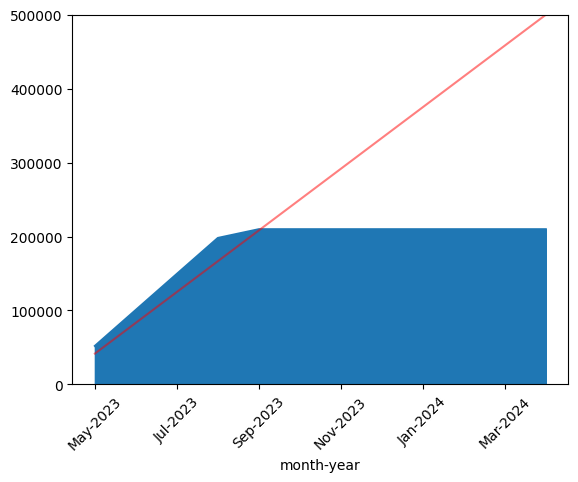

In [80]:
fig, ax = plt.subplots()
pivot.plot(kind="area", x="month-year", y='cumulative_total_cost', stacked=True, legend=False, rot=45, ax = ax)
pivot.plot(kind="line", x="month-year", y='cumulative_expected_cost', color='red', legend=False, rot=45, ax = ax, alpha=0.5)
ax.set_ylim(0, max(pivot['cumulative_total_cost'].max(), pivot['cumulative_expected_cost'].max()))
plt.show()